#CRM - RFM - CLTV PREDICTION ANALYSIS

**Customer Lifetime Value (CLTV) is the monetary value that a customer brings to a company over the course of its relationship and communication with that company. By identifying the benefits that customers can provide in the future, a company can align its customer relationships and take a more value-oriented approach. One of the biggest concerns of many national and international companies is the calculation of customer lifetime value.
CLTV also plays an important role in determining marketing budgets. Having calculated the unit costs of acquiring new customers, a company can use customer lifetime value calculations to compare marketing activities for existing customers with efforts to find new customers.**

**BG/NBD Model (Beta Geometric / Negative Binomial Distribution):**

The beta geometric distribution and the negative binomial distribution are discrete probability distributions studied in statistics and probability. Using these distributions, the expected number of purchase transactions can be calculated. First of all, a random variable is defined as a variable that derives its values from the results of an experiment, where "expected" is used to refer to the expected value of a random variable. The expected value of a random variable is the mean of that random variable.
The main objective is to model the purchasing behavior of the general population with probability distributions and reduce them to individuals.
The BG/NBD model is also a probabilistic model that can be used as a stand-alone sales forecasting model. BG/NBD probabilistically models two processes for the expected number of transactions:

**a)Purchasing process:**
- It is the modeling of the purchasing process. In this context, the number of transactions to be performed by a customer in a given time period is distributed possion with the transaction rate parameter.
- In other words, a user will continue to make random purchases around their transaction rate for as long as they are alive.
- Transaction rates vary for each customer and are gamma distributed for the entire audience.
Dropout process

**b)Churn:**
- Models the process by which  a user leaves the brand .
- Each customer has a dropout rate(dropout probability) with probability p.
- A customer drops with a certain probability after making a purchase.
- The dropout rate varies for each customer and is beta-distributed for the entire audience .



**Gamma-Gamma model:**

It is used to estimate how much profit a customer can make on average per transaction, and themonetary value of the customer's transactions is randomly distributed around the average of their transaction values.
The average transaction value may vary across users over time, but not for a single user.
The average transaction value is gamma distributed across all customers


**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Dataset Information**

The dataset consists of information derived from the historical shopping behaviors of customers who made their most recent purchases in the years 2020-2021 through an OmniChannel approach (both online and offline shopping).

**master_id:** Unique customer identifier

**order_channel:** Indicates the platform/channel used for making the purchase (Android, iOS, Desktop, Mobile, Offline)

**last_order_channel:** Represents the channel through which the most recent purchase was made

**first_order_date:** The date of the customer's first purchase

**last_order_date:** The date of the customer's most recent purchase

**last_order_date_online:** The date of the customer's most recent online purchase

**last_order_date_offline:** The date of the customer's most recent offline purchase

**order_num_total_ever_online:** Total number of purchases made by the customer online

**order_num_total_ever_offline:** Total number of purchases made by the customer offline

**customer_value_total_ever_offline:** Total amount spent by the customer on offline purchases

**customer_value_total_ever_online:** Total amount spent by the customer on online purchases

**interested_in_categories_12:** List of categories in which the customer has made purchases in the last 12 months

 # Imports and settings

In [ ]:
pip install lifetimes

In [3]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

**Functions**

In [4]:
def check_df(dataframe,head=5):
    print("##Shape##")
    print(dataframe.shape)
    print("##Types##")
    print(dataframe.dtypes)
    print("##Head##")
    print(dataframe.head(head))
    print("##Tail##")
    print(dataframe.tail(head))
    print("##Missingentries##")
    print(dataframe.isnull().sum())
    print("##Quantiles##")
    print(dataframe.quantile([0,0.05,0.50,0.95,0.99,1]).T)
    print("##generalinformation##")
    print(dataframe.describe().T)

In [5]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [6]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [11]:
def grab_col_names(dataframe,cat_th=10,car_th=20):
    """

    Verisetindekikategorik,numerikvekategorikfakatkardinaldeğişkenlerinisimleriniverir.
    Not:Kategorikdeğişkenleriniçerisinenumerikgörünümlükategorikdeğişkenlerdedahildir.

    Parameters
    ------
    dataframe:dataframe
    Değişkenisimlerialınmakistenilendataframe
    cat_th:int,optional
    numerikfakatkategorikolandeğişkenleriçinsınıfeşikdeğeri
    car_th:int,optinal
    kategorikfakatkardinaldeğişkenleriçinsınıfeşikdeğeri

    Returns
    ------
    cat_cols:list
    Kategorikdeğişkenlistesi
    num_cols:list
    Numerikdeğişkenlistesi
    cat_but_car:list
    Kategorikgörünümlükardinaldeğişkenlistesi

    Examples
    ------
    importseabornassns
    df=sns.load_dataset("iris")
    print(grab_col_names(df))


    Notes
    ------
    cat_cols+num_cols+cat_but_car=toplamdeğişkensayısı
    num_but_catcat_cols'uniçerisinde.
    Returnolan3listetoplamıtoplamdeğişkensayısınaeşittir:cat_cols+num_cols+cat_but_car=değişkensayısı

    """

    #cat_cols,cat_but_car
    cat_cols=[col for col in dataframe.columns if dataframe[col].dtypes=="O"]
    num_but_cat=[col for col in dataframe.columns if dataframe[col].nunique()<cat_th and
    dataframe[col].dtypes != "O"]
    cat_but_car=[col for col in dataframe.columns if dataframe[col].nunique()>car_th and
    dataframe[col].dtypes == "O"]
    cat_cols=cat_cols+num_but_cat
    cat_cols=[col for col in cat_cols if col not in cat_but_car]

    #num_cols
    num_cols=[col for col in dataframe.columns if dataframe[col].dtypes!="O"]
    num_cols=[col for col in num_cols if col not in num_but_cat]

    print(f"Observations:{dataframe.shape[0]}")
    print(f"Variables:{dataframe.shape[1]}")
    print(f'cat_cols:{len(cat_cols)}')
    print(f'num_cols:{len(num_cols)}')
    print(f'cat_but_car:{len(cat_but_car)}')
    print(f'num_but_cat:{len(num_but_cat)}')
    return cat_cols,num_cols,cat_but_car

**Prepare the data**

In [12]:
df_ = pd.read_csv("/content/flo_data_20k.csv")
df = df_.copy()

In [13]:
check_df(df)

##Shape##
(19945, 12)
##Types##
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##Head##
                              master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online       interested_in_categories_12
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline       2020-10-30 

**Make a new variable for the total or orders for each client**

In [14]:
df["order_num_total_ever"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["total_Value_both"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

**Transform date variables into datatime64 type:**

In [15]:
df["first_order_date"] = df["first_order_date"].astype("datetime64[ns]")
df["last_order_date"] = df["last_order_date"].astype("datetime64[ns]")
df["last_order_date_online"] = df["last_order_date_online"].astype("datetime64[ns]")
df["last_order_date_offline"] = df["last_order_date_offline"].astype("datetime64[ns]")

**Take a look at the order channel:**

In [16]:
gb = df.groupby("order_channel").agg({"order_num_total_ever": "sum",
                                      "total_Value_both": "sum",
                                      "master_id" : "count"})

In [17]:
gb.reset_index()

,order_channel,order_num_total_ever,total_Value_both,master_id
0,Android App,52269.000,7819062.760,9495
1,Desktop,10920.000,1610321.460,2735
2,Ios App,15351.000,2525999.930,2833
3,Mobile,21679.000,3028183.160,4882


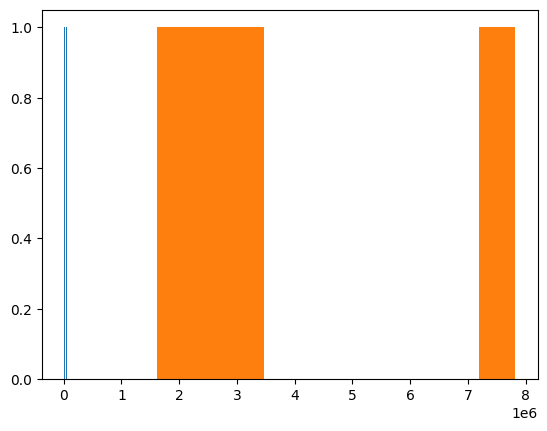

In [18]:
plt.hist(gb["order_num_total_ever"])
plt.hist(gb["total_Value_both"])
plt.show(block = True)

**Get our top 10 customers in terms of total value**

In [19]:
df.sort_values("total_Value_both", ascending=False).head(10)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,order_num_total_ever,total_Value_both
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,Android App,Desktop,2013-10-11,2021-04-30,2021-04-30,2020-12-24,200.000,2.000,684.970,45220.130,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",202.000,45905.100
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,Android App,Android App,2018-08-06,2021-02-23,2021-02-23,2020-07-06,67.000,1.000,130.490,36687.800,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",68.000,36818.290
7613,73fd19aa-9e37-11e9-9897-000d3a38a36f,Ios App,Offline,2014-01-14,2021-05-18,2021-01-30,2021-05-18,81.000,1.000,1263.760,32654.340,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",82.000,33918.100
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,Ios App,Offline,2021-03-01,2021-04-13,2021-03-18,2021-04-13,10.000,1.000,538.940,30688.470,"[ERKEK, KADIN, AKTIFSPOR]",11.000,31227.410
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,Android App,Offline,2021-04-07,2021-04-27,2021-04-07,2021-04-27,1.000,3.000,18119.140,2587.200,[AKTIFSPOR],4.000,20706.340
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,Desktop,Desktop,2020-02-16,2021-04-30,2021-04-30,2020-12-18,66.000,4.000,843.680,17599.890,"[ERKEK, KADIN, AKTIFSPOR]",70.000,18443.570
8068,d696c654-2633-11ea-8e1c-000d3a38a36f,Ios App,Ios App,2017-05-10,2021-04-13,2021-04-13,2019-08-15,69.000,1.000,82.480,16836.090,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",70.000,16918.570
163,fef57ffa-aae6-11e9-a2fc-000d3a38a36f,Mobile,Desktop,2016-11-08,2021-05-12,2021-05-12,2020-07-09,36.000,1.000,180.730,12545.370,"[ERKEK, AKTIFSPOR]",37.000,12726.100
7223,cba59206-9dd1-11e9-9897-000d3a38a36f,Android App,Android App,2013-02-21,2021-05-09,2021-05-09,2020-01-25,130.000,1.000,49.990,12232.250,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",131.000,12282.240
18767,fc0ce7a4-9d87-11e9-9897-000d3a38a36f,Desktop,Desktop,2018-11-24,2020-11-11,2020-11-11,2019-12-06,18.000,2.000,64.970,12038.180,"[ERKEK, KADIN]",20.000,12103.150


**Get our top 10 customers in terms of total orders**

In [20]:
df.sort_values("order_num_total_ever", ascending=False).head(10)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,order_num_total_ever,total_Value_both
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,Android App,Desktop,2013-10-11,2021-04-30,2021-04-30,2020-12-24,200.000,2.000,684.970,45220.130,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",202.000,45905.100
7223,cba59206-9dd1-11e9-9897-000d3a38a36f,Android App,Android App,2013-02-21,2021-05-09,2021-05-09,2020-01-25,130.000,1.000,49.990,12232.250,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",131.000,12282.240
8783,a57f4302-b1a8-11e9-89fa-000d3a38a36f,Android App,Offline,2019-08-07,2020-11-04,2020-09-07,2020-11-04,2.000,109.000,10239.460,143.980,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",111.000,10383.440
2619,fdbe8304-a7ab-11e9-a2fc-000d3a38a36f,Android App,Offline,2018-10-18,2020-06-30,2018-10-18,2020-06-30,1.000,87.000,8432.250,139.980,[ERKEK],88.000,8572.230
6322,329968c6-a0e2-11e9-a2fc-000d3a38a36f,Ios App,Ios App,2019-02-14,2021-04-05,2021-04-05,2020-02-17,2.000,81.000,3997.550,242.810,[ERKEK],83.000,4240.360
7613,73fd19aa-9e37-11e9-9897-000d3a38a36f,Ios App,Offline,2014-01-14,2021-05-18,2021-01-30,2021-05-18,81.000,1.000,1263.760,32654.340,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",82.000,33918.100
9347,44d032ee-a0d4-11e9-a2fc-000d3a38a36f,Mobile,Mobile,2019-02-11,2021-02-11,2021-02-11,2020-12-24,3.000,74.000,4640.770,543.280,"[KADIN, AKTIFSPOR]",77.000,5184.050
10954,b27e241a-a901-11e9-a2fc-000d3a38a36f,Mobile,Mobile,2015-09-12,2021-04-01,2021-04-01,2019-10-08,72.000,3.000,292.930,5004.950,"[AKTIFCOCUK, ERKEK, KADIN, AKTIFSPOR]",75.000,5297.880
8068,d696c654-2633-11ea-8e1c-000d3a38a36f,Ios App,Ios App,2017-05-10,2021-04-13,2021-04-13,2019-08-15,69.000,1.000,82.480,16836.090,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",70.000,16918.570
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,Desktop,Desktop,2020-02-16,2021-04-30,2021-04-30,2020-12-18,66.000,4.000,843.680,17599.890,"[ERKEK, KADIN, AKTIFSPOR]",70.000,18443.570


In [21]:
cat_cols,num_cols,cat_but_car = grab_col_names(df)
for col in num_cols:
    replace_with_thresholds(df,col)

Observations:19945
Variables:14
cat_cols:2
num_cols:10
cat_but_car:2
num_but_cat:0


#RFM

**Take Today's date as 2 days after the last date of the data.**

In [22]:
df["last_order_date_online"].max()
today_date = dt.datetime(2021, 6, 2)

**As frequency is the total orders a client has and monetary is the total spent money we can just
rename our variables as they're the same as we want. we only have to calculate recency.**

In [23]:
df["Recency"] = (today_date - df["last_order_date"]).dt.days

**Make an RFM dataframe**

In [24]:
rfm = df[["Recency","order_num_total_ever","total_Value_both"]]
rfm.columns = ['Recency', 'Frequency', 'Monetary']

**Make RFM scores and save them in RF_SSCORE.**

In [25]:
rfm["recency_score"] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

rfm["frequency_score"] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm["RF_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

**Make segments for our RF scores**

In [26]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

In [27]:
rfm['segment'] = rfm['RF_SCORE'].replace(seg_map, regex=True)

In [28]:
rfm[["segment", "Recency", "Frequency", "Monetary"]].groupby("segment").mean()

,Recency,Frequency,Monetary
segment,,,
about_to_sleep,114.785,2.401,359.009
at_Risk,242.607,4.472,646.610
cant_loose,236.444,10.604,1470.471
champions,18.107,8.790,1365.135
hibernating,248.950,2.394,366.267
loyal_customers,83.595,8.336,1199.024
need_attention,114.829,3.728,562.143
new_customers,18.918,2.000,339.956
potential_loyalists,38.156,3.304,529.147


In [29]:
df["segment"] = rfm["segment"]

#Customer Lifetime Value

In [30]:
df = df_.copy()

In [31]:
df["total_num_both"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["total_Value_both"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

**5 convert to dates**

In [32]:
df["first_order_date"] = df["first_order_date"].astype("datetime64[ns]")
df["last_order_date"] = df["last_order_date"].astype("datetime64[ns]")
df["last_order_date_online"] = df["last_order_date_online"].astype("datetime64[ns]")
df["last_order_date_offline"] = df["last_order_date_offline"].astype("datetime64[ns]")

In [33]:
cat_cols,num_cols,cat_but_car = grab_col_names(df)
for col in num_cols:
    replace_with_thresholds(df,col)

Observations:19945
Variables:14
cat_cols:2
num_cols:10
cat_but_car:2
num_but_cat:0


In [34]:
df["recency_CLTV_WEEKLY"] = (df["last_order_date"] - df["first_order_date"]).dt.days/7
df["T_weekly"] = (today_date - df["first_order_date"]).dt.days/7
df["frequency"] = df["total_num_both"]
df["monetary_cltv_avg"] = df["total_Value_both"]/df["total_num_both"]

In [35]:
cltv_c = df[["recency_CLTV_WEEKLY","T_weekly","frequency","monetary_cltv_avg"]]

#BG/NBD

In [36]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_c["frequency"],
        cltv_c["recency_CLTV_WEEKLY"],
        cltv_c["T_weekly"])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 74.22, b: 0.00, r: 3.58>

**Expected sales in the coming 3 months**

In [37]:
df["exp_sales_3_month"] = bgf.predict(4 * 3,
                                               df['frequency'],
                                               df['recency_CLTV_WEEKLY'],
                                               df['T_weekly'])

**Expected sales in the coming 6 months**

In [38]:
df["exp_sales_6_month"] = bgf.predict(4 * 6,
                                               df['frequency'],
                                               df['recency_CLTV_WEEKLY'],
                                               df['T_weekly'])

# GAMMA GAMMA

In [39]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_c["frequency"],cltv_c["monetary_cltv_avg"])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [40]:
cltv = ggf.customer_lifetime_value(bgf,
                                cltv_c['frequency'],
                                cltv_c['recency_CLTV_WEEKLY'],
                                cltv_c['T_weekly'],
                                cltv_c['monetary_cltv_avg'],
                                time=6, # 6 months
                                freq="W",# T frequency info.
                                discount_rate=0.01)

In [41]:
df["cltv"] = cltv

In [42]:
df.sort_values(by="cltv", ascending=False).head(20)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_num_both,total_Value_both,recency_CLTV_WEEKLY,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,Android App,Offline,2021-04-07,2021-04-27,2021-04-07,2021-04-27,1.000,3.000,3019.882,2587.200,[AKTIFSPOR],4.000,8844.919,2.857,8.000,4.000,2211.230,1.106,2.213,5305.916
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,Ios App,Offline,2021-03-01,2021-04-13,2021-03-18,2021-04-13,10.000,1.000,538.940,7799.541,"[ERKEK, KADIN, AKTIFSPOR]",11.000,8844.919,6.143,13.286,11.000,804.084,2.000,3.999,3415.153
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,Android App,Android App,2019-12-27,2021-05-30,2021-05-30,2019-12-27,15.000,1.000,229.980,7799.541,"[AKTIFCOCUK, KADIN, AKTIFSPOR]",16.000,8844.919,74.286,74.714,16.000,552.807,1.578,3.155,1845.773
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,Desktop,Desktop,2019-06-25,2020-06-21,2020-06-21,2019-06-25,6.000,1.000,79.990,7665.280,"[AKTIFCOCUK, ERKEK, COCUK, KADIN, AKTIFSPOR]",7.000,7745.270,51.714,101.143,7.000,1106.467,0.724,1.448,1713.311
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,Desktop,Desktop,2020-02-16,2021-04-30,2021-04-30,2020-12-18,48.500,4.000,843.680,7799.541,"[ERKEK, KADIN, AKTIFSPOR]",52.000,8844.919,62.714,67.429,52.000,170.095,4.709,9.417,1685.605
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,Desktop,Desktop,2020-10-03,2020-10-27,2020-10-27,2020-10-25,5.000,3.000,1333.000,3476.810,"[KADIN, AKTIFSPOR]",8.000,4809.810,3.429,34.571,8.000,601.226,1.277,2.555,1639.198
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,Ios App,Ios App,2021-03-02,2021-05-09,2021-05-09,2021-03-07,13.000,4.000,2575.820,1841.890,"[AKTIFCOCUK, COCUK, KADIN, AKTIFSPOR]",17.000,4417.710,9.714,13.143,17.000,259.865,2.827,5.654,1554.710
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,Android App,Android App,2021-03-27,2021-05-24,2021-05-24,2021-03-27,1.000,1.000,1074.890,650.490,"[ERKEK, COCUK, KADIN]",2.000,1725.380,8.286,9.571,2.000,862.690,0.799,1.599,1549.272
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,Android App,Android App,2020-04-16,2021-04-19,2021-04-19,2020-11-03,27.000,4.000,585.840,6498.590,"[AKTIFCOCUK, COCUK, KADIN, AKTIFSPOR]",31.000,7084.430,52.571,58.857,31.000,228.530,3.118,6.237,1502.462
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,Mobile,Mobile,2021-02-12,2021-05-27,2021-05-27,2021-02-12,2.000,1.000,130.960,2099.800,"[AKTIFCOCUK, COCUK, KADIN, AKTIFSPOR]",3.000,2230.760,14.857,15.714,3.000,743.587,0.878,1.756,1433.729


In [43]:
df["segment"] = pd.qcut(df["cltv"],4,labels=("D","C","B","A"))

In [44]:
df.groupby("segment").agg(
    {"count", "mean", "sum"})

order_num_total_ever_online                 order_num_total_ever_offline                 customer_value_total_ever_offline                   customer_value_total_ever_online                   total_num_both                 total_Value_both                   recency_CLTV_WEEKLY                  T_weekly                  frequency                 monetary_cltv_avg                   exp_sales_3_month                exp_sales_6_month                   cltv                  
                               mean       sum count                         mean       sum count                              mean         sum count                             mean         sum count           mean       sum count             mean         sum count                mean        sum count     mean        sum count      mean       sum count              mean         sum count              mean      sum count              mean      sum count    mean         sum count
segment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
D                             2.120 10571.000  4987                        1.646  8207.000  4987                           148.809  742109.460  4987                          202.851 1011616.300  4987          3.765 18778.000  4987          351.659 1753725.760  4987             139.074 693560.714  4987  162.414 809957.571  4987     3.765 18778.000  4987            93.255  465064.239  4987             0.408 2032.211  4987             0.815 4064.422  4987  80.124  399576.729  4987
C                             2.573 12830.000  4986                        1.820  9074.000  4986                           202.855 1011436.470  4986                          326.048 1625672.930  4986          4.396 21917.000  4986          528.903 2637109.400  4986              92.551 461460.286  4986  112.900 562919.000  4986     4.396 21917.000  4986           125.944  627954.728  4986             0.525 2617.105  4986             1.050 5234.209  4986 138.218  689155.331  4986
B                             3.092 15418.500  4986                        2.005  9996.000  4986                           274.108 1366701.960  4986                          480.245 2394502.370  4986          5.097 25415.000  4986          754.353 3761204.330  4986              82.014 408920.143  4986  100.489 501037.571  4986     5.097 25415.000  4986           160.598  800744.016  4986             0.602 3000.862  4986             1.204 6001.723  4986 199.655  995477.664  4986
A                             4.584 22856.500  4986                        2.074 10343.000  4986                           381.934 1904320.834  4986                          949.736 4735382.143  4986          6.736 33588.000  4986         1338.729 6674904.467  4986              67.407 336089.286  4986   82.647 412075.857  4986     6.736 33588.000  4986           228.637 1139985.963  4986             0.782 3898.140  4986             1.564 7796.279  4986 364.678 1818286.488  4986

In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.000,3.092,3.814,1.000,1.000,2.000,4.000,48.500
order_num_total_ever_offline,19945.000,1.886,1.435,1.000,1.000,1.000,2.000,16.000
customer_value_total_ever_offline,19945.000,251.921,251.023,10.000,99.990,179.980,319.970,3019.882
customer_value_total_ever_online,19945.000,489.705,632.606,12.990,149.980,286.460,578.440,7799.541
total_num_both,19945.000,4.999,4.260,2.000,3.000,4.000,6.000,52.000
total_Value_both,19945.000,743.392,701.942,44.980,339.980,545.270,897.780,8844.919
recency_CLTV_WEEKLY,19945.000,95.263,74.589,0.000,50.429,76.571,109.429,433.429
T_weekly,19945.000,114.615,74.771,0.857,74.000,93.143,119.571,437.286
frequency,19945.000,4.999,4.260,2.000,3.000,4.000,6.000,52.000
monetary_cltv_avg,19945.000,152.106,74.519,22.490,103.560,136.774,182.410,2211.230


In [49]:
df.to_csv("final.csv")